# Imports

In [ ]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [80]:
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import tensorflow_addons as tfa

PATH = pathlib.Path.cwd()
DATA_DIR = PATH.parent / 'data'
EXAMPLES_DIR = DATA_DIR / 'examples'
IMAGE_SHAPE = [128,128]

MODEL_NAME = '2021-08-26-2100 100E'

In [21]:
# we only want the generator
model = tf.keras.models.load_model(f'models/{MODEL_NAME}')
model = model.generator

In [61]:
def decode_sketch(sketch_path, image_shape=[128,128], method='nearest'):
    # takes a png file path and returns a tensor
    sketch = tf.io.read_file(sketch_path)
    sketch = tf.io.decode_png(sketch)
    sketch = tf.cast(sketch, tf.float32) / 255
    return tf.image.resize(sketch, image_shape, method=method)

In [62]:
def show_prediction(img, pred, size=3):
    """Take the sketch and prediction and plot alongside"""
    fig, axs = plt.subplots(1, 2, figsize=(size*2, size*1))

    axs[0].imshow(img.numpy(), cmap='gray')
    axs[1].imshow((pred.numpy().squeeze()+1)/2)

    # remove axis ticks
    for ax in matplotlib.cbook.flatten(axs):
        ax.set(xticks=[], yticks=[])

    # set titles
    axs[0].set_title('Sketch')
    axs[1].set_title('Prediction')

    # adjust styling and show
    fig.patch.set_facecolor('white')     
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    plt.close()

In [ ]:
def predict_and_show(model, filepath, size=3):
    """Resizing with method=area does much much better on the MSPaint examples"""
    
    # load file and make prediction
    sketch = decode_sketch(str(filepath), method='area')
    
    # hand drawn sketches need extra preprocessing
    if sketch.shape[-1]==3:
        sketch = preprocess_sketch(sketch)
    
    # predict and plot
    image = model(sketch[tf.newaxis, ...])
    show_prediction(sketch, image, size)

The background colouring is probably due to backgrounds existing in the training set.

The more detailed frog images are similar quality to the training data, so this approch to inference seems to work well.

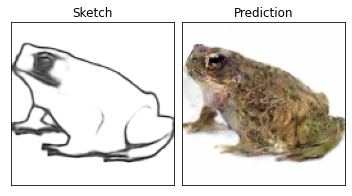

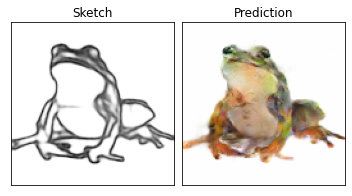

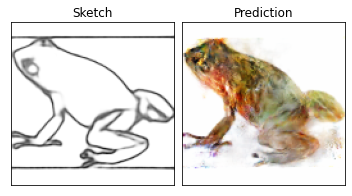

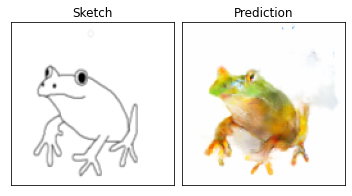

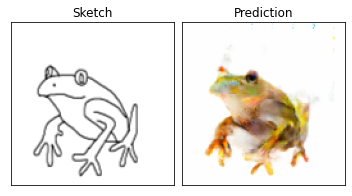

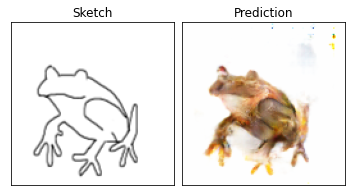

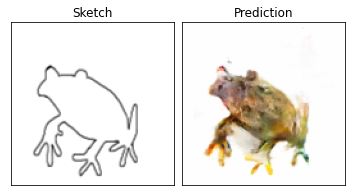

In [148]:
def preprocess_sketch(sketch, thresh=0.8):
    """MSPaint sketches need extra processing
    Otherwise they look nothing like the training data"""
    
    # convert from rgb to grayscale
    sketch = tf.image.rgb_to_grayscale(sketch)
    
    # convert to binary map - not great results
    # sketch = tf.where(sketch>=thresh, tf.ones(sketch.shape), sketch)
    # sketch = tf.where(sketch<thresh, tf.zeros(sketch.shape), sketch)

    # smooth image    
    sketch = tfa.image.gaussian_filter2d(sketch, sigma=1, filter_shape=(2,2))
    
    # thicken lines then add filter again - not useful
    # sketch = tf.where(sketch>=thresh, tf.ones(sketch.shape), sketch)
    # sketch = tf.where(sketch<thresh, tf.zeros(sketch.shape), sketch)
    # sketch = tfa.image.gaussian_filter2d(sketch, sigma=1, filter_shape=(3,3))
    return sketch

## don't predict, just check preprocessing  
# for i, filepath in enumerate(EXAMPLES_DIR.glob('*')):
#     sketch = decode_sketch(str(filepath), method='area')
#     if sketch.shape[-1]==3: sketch = preprocess_sketch(sketch) 
#     plt.imshow(sketch.numpy(), cmap='gray')
#     plt.show()
#     plt.close()
#     if i>=1: break

 
for filepath in EXAMPLES_DIR.glob('*'):
    predict_and_show(model, filepath)